# Libraries

In [2]:
# Import libraries

from os import listdir
import string
import pandas as pd
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from attention import AttentionLayer
import pickle
import warnings
import re, string, unicodedata
import nltk
import pickle
import inflect
from bs4 import BeautifulSoup
import tensorflow as tf
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 

pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [ ]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

# Load data

In [3]:
x_tr = np.load("/content/drive/My Drive/bidirectional/final_data/x_tr.npy")
y_tr = np.load("/content/drive/My Drive/bidirectional/final_data/y_tr.npy")
x_val = np.load("/content/drive/My Drive/bidirectional/final_data/x_val.npy")
y_val = np.load("/content/drive/My Drive/bidirectional/final_data/y_val.npy")

In [5]:
def open_test_data_y():
    return open('/content/drive/My Drive/bidirectional/y_tokenizer.pickle', 'rb')

with open_test_data_y() as f:
    y_tokenizer = pickle.load(f) 

def open_test_data_x():
    return open('/content/drive/My Drive/bidirectional/x_tokenizer.pickle', 'rb')

with open_test_data_x() as f:
    x_tokenizer = pickle.load(f) 

def open_vars():
    return open('/content/drive/My Drive/bidirectional/vars.pkl', 'rb')

with open_vars() as f:  # Python 3: open(..., 'rb')
    x_voc, y_voc = pickle.load(f)

In [6]:
max_text_len=300
max_summary_len=12

# Modeling

In [ ]:
from tensorflow.keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder

encoder_inputs = Input(shape=(max_text_len,))
#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)
#encoder lstm 1
encoder_lstm1 = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm1(enc_emb)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

# Decoder

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,_, _, = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer

attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 100)     4923400     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 300, 600), ( 962400      embedding[0][0]                  
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [7]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="drive/MyDrive/bidirectional/10epochs/saved_model",
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

csv_logger = tf.keras.callbacks.CSVLogger('drive/MyDrive/bidirectional/training_bidirectional_10.log', append=True)

In [1]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:],
                  
                  epochs=10, verbose = 1, callbacks=[model_checkpoint_callback, csv_logger],
                  validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

In [10]:
model.save('drive/MyDrive/bidirectional/10epochs/saved_model')

INFO:tensorflow:Assets written to: drive/MyDrive/bidirectional/final10/assets


#### Loss plot

In [3]:
history = pd.read_csv("training_bidirectional_10.log")

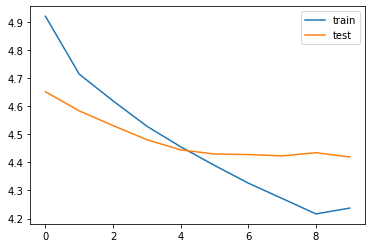

In [4]:
from matplotlib import pyplot
pyplot.plot(history['loss'], label='train')
pyplot.plot(history['val_loss'], label='test')
pyplot.legend()